# NN

In [15]:
# !sudo pip3 install pandas
# !sudo pip3 install matplotlib seaborn
# !sudo pip3 install scipy scikit-learn

# !sudo pip3 install fastprogress
# !sudo pip3 install tqdm

# !sudo pip3 install lightning==1.9
# !sudo pip3 install lightgbm

In [2]:
import random, os
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import scipy.stats
from tqdm import tqdm
from fastprogress import master_bar, progress_bar

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models

In [3]:
torch.set_float32_matmul_precision('medium')  # 或 'high'

In [4]:
DATA_ROOT = '../input/'
cut_inf, cut_sup = 39, 321

## Metric

In [5]:
class ParticipantVisibleError(Exception):
    pass
def ariel_score(
        solution,
        submission,
        naive_mean,
        naive_sigma,
        sigma_true
    ):
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    if submission.min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')

    n_wavelengths = 283

    y_pred = submission[:, :n_wavelengths]
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission[:, n_wavelengths:], a_min=10**-15, a_max=None)
    y_true = solution

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    #print(GLL_pred, GLL_true, GLL_mean)
    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return submit_score #float(np.clip(submit_score, 0.0, 1.0))

## Prepare Data

In [6]:
train_adc_info = pd.read_csv(f'{DATA_ROOT}/train_adc_info.csv', index_col='planet_id')
train_labels = pd.read_csv(f'{DATA_ROOT}/train_labels.csv', index_col='planet_id')

In [7]:
train_processed = np.load('trim_train_processed.npz')
trim_f_raw_train, trim_a_raw_train = train_processed['f_raw_train'], train_processed['a_raw_train']

trim_a_raw_train = trim_a_raw_train[:, :, cut_inf:cut_sup]
trim_a_raw_train_mean = trim_a_raw_train.mean(axis=-1)
trim_f_raw_train.shape, trim_a_raw_train.shape, trim_a_raw_train_mean.shape

((673, 67500), (673, 5625, 282), (673, 5625))

In [8]:
# f_signal: 一共采样 67500 步，为减少计算量，每 180 步组成一个 bin，bin内取平均，步数减少为 375
# a_signal: 一共采样 5625 步，为减少计算量，每 15 步组成一个 bin，bin内取平均，步数减少为 375
bin_trim_f_raw_train = trim_f_raw_train.reshape(673, 375, 180).mean(axis=-1)
bin_trim_a_raw_train = trim_a_raw_train.reshape(673, 375, 15, 282).mean(axis=2)

pre_train = np.concatenate((bin_trim_f_raw_train[:, :, np.newaxis], bin_trim_a_raw_train), axis=-1)
pre_train.shape

(673, 375, 283)

In [9]:
# Transit phase detector

def phase_detector(signal):
    phase1, phase2 = None, None
    best_drop = 0
    for i in range(50,150):        
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase1 = i+20+5
            best_drop = t1
    
    best_drop = 0
    for i in range(200,300):
        t1 = signal[i:i+20].max() - signal[i:i+20].min()
        if t1 > best_drop:
            phase2 = i-5
            best_drop = t1
    
    return phase1, phase2

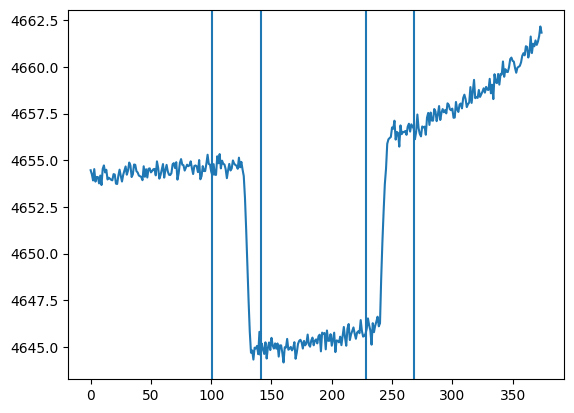

In [11]:
n = 205
plt.plot(pre_train[n,:,1:].mean(axis=1))
p1, p2 = phase_detector(pre_train[n,:,1:].mean(axis=1))
plt.axvline(p1)
plt.axvline(p2)
plt.axvline(p1-40)
plt.axvline(p2+40)

In [10]:
# Normalize
train = pre_train.copy()
for i in range(len(train_adc_info)):
    p1, p2 = phase_detector(pre_train[i, :, 1:].mean(axis=1))
    train[i] = (train[i] - pre_train[i, p1:p2].mean(axis=0)) / pre_train[i, list(range(p1-40)) + list(range(p2+40 ,375))].mean(axis=0) * 1000.0

In [61]:
train.min(), train.mean(), train.max(), train.std()

(-37.13372, 1.6503725, 42.10906, 2.7779722)

In [ ]:
np.save('train.npy', train)

## Model

### Quantile Regression：预测随机变量分布

- 普通的线性回归用于预测目标变量(target)的均值；
- 分位数回归可以用来预测目标变量的分位数；

In [14]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

In [22]:
from sklearn.linear_model import LinearRegression

In [16]:
n = 10000
X, y = make_regression(n_samples=n, n_features=1, n_informative=1, n_targets=1)
X = X.flatten() + np.random.normal(loc=6, scale=0.5, size=n)
y = y + np.random.normal(loc=300, scale=40, size=n)

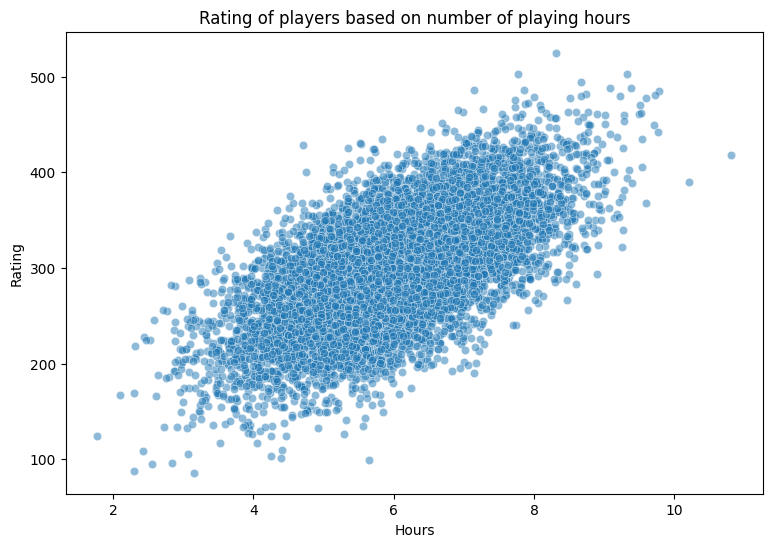

In [19]:
df = pd.DataFrame({'hours': X.flatten(), 'rating': y})
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df, x='hours', y='rating', alpha=0.5)
plt.title('Rating of players based on number of playing hours')
plt.xlabel('Hours')
_ = plt.ylabel('Rating')

In [20]:
df_train, df_test = train_test_split(df, test_size=0.20, shuffle=False)
X_train, y_train = df_train[['hours']], df_train['rating']
X_test, y_test = df_test[['hours']], df_test['rating']

In [21]:
models = {}
df_pred = df_test.copy()
for alpha in [0.2, 0.5, 0.8]:
    model = LGBMRegressor(objective='quantile', alpha=alpha)
    model.fit(X_train, y_train)
    df_pred[str(alpha)] = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training from score 249.932358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training from score 300.222534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 1
[LightGBM] [Info] Start training

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
df_pred['lr'] = model.predict(X_test)

Text(0.5, 0, 'Hours')

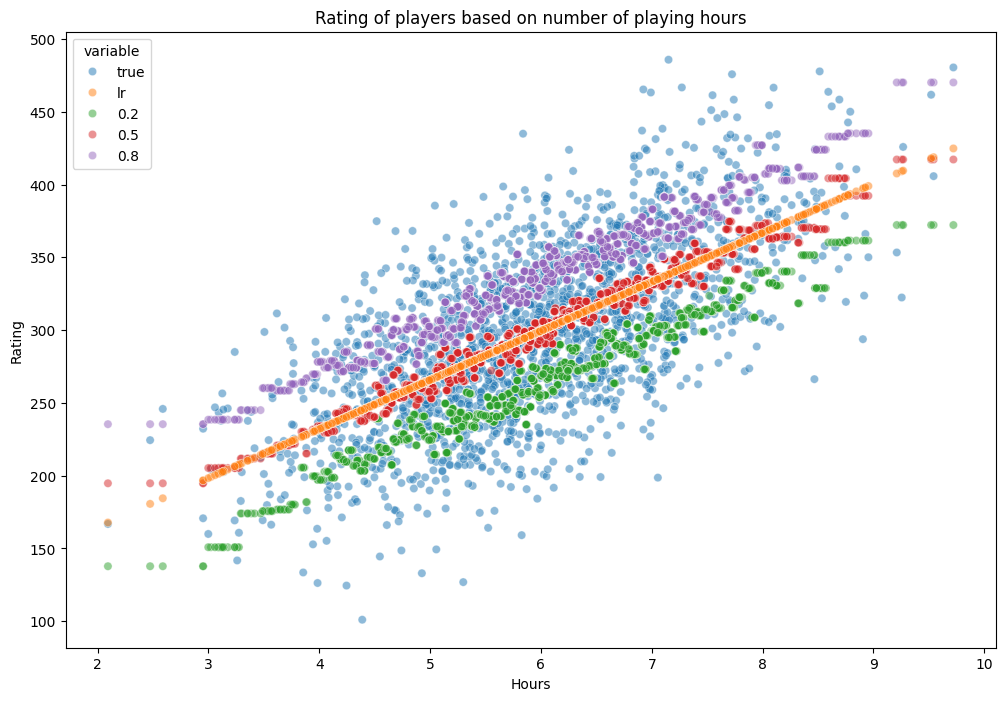

In [26]:
plt.figure(figsize=(12, 8))
df_pred_melted = pd.melt(df_pred.rename(columns={'rating': 'true'}), id_vars=['hours'])
sns.scatterplot(data=df_pred_melted, x='hours', y='value', hue='variable', hue_order=['true', 'lr', '0.2', '0.5', '0.8'], alpha=0.5)
plt.title('Rating of players based on number of playing hours')
plt.ylabel('Rating')
plt.xlabel('Hours')

### Quantile Loss

给定分位数 $\alpha$，分位数损失定义为：

\begin{equation}
  \ell (y, \hat{y}) =
    \begin{cases}
      \alpha \cdot (y - \hat{y}) & \text{, $\hat{y} \leq y$ }\\
      (1 - \alpha) \cdot (\hat{y} - y) & \text{, $\hat{y} > y$}\\
    \end{cases}       
\end{equation}

为方便理解，取80-分位数用于说明，即 $\alpha=0.8$，此时分位数损失为：

\begin{equation}
  \ell (y, \hat{y}) =
    \begin{cases}
      0.8 \cdot (y - \hat{y}) & \text{, $\hat{y} \leq y$ }\\
      0.2 \cdot (\hat{y} - y) & \text{, $\hat{y} > y$}\\
    \end{cases}       
\end{equation}

我们可以看到，分位数损失对低估预测的惩罚是高估预测的4倍。通过这种方式，模型会对低估的错误更加苛刻，并更频繁地预测较高的值。结果是，拟合的模型在大约80%的情况下会高估结果，而在20%的情况下会产生低估。

现在假设对于同一个目标获得了两个预测。目标值是40，而预测值分别是30和50。让我们分别计算这两种情况下的分位数损失。尽管两种情况下的绝对误差都是10，但损失值是不同的：

- 对于预测值30，损失值为 l = 0.8 * 10 = 8
- 对于预测值50，损失值为 l = 0.2 * 10 = 2。

为了让损失最小化，模型倾向于向上挑战预测值(高估)。

In [27]:
def quantile_loss(alpha, true, pred):
    return alpha * (true - pred) if true > pred else (1 - alpha) * (pred - true)

### 挑选分位数用以估算sigma

如果目标变量(target)的分布符合正态分布，则其分位数与 $\sigma$，对应关系如下，我们可以通过分位数回归来预测 $\sigma$ 值
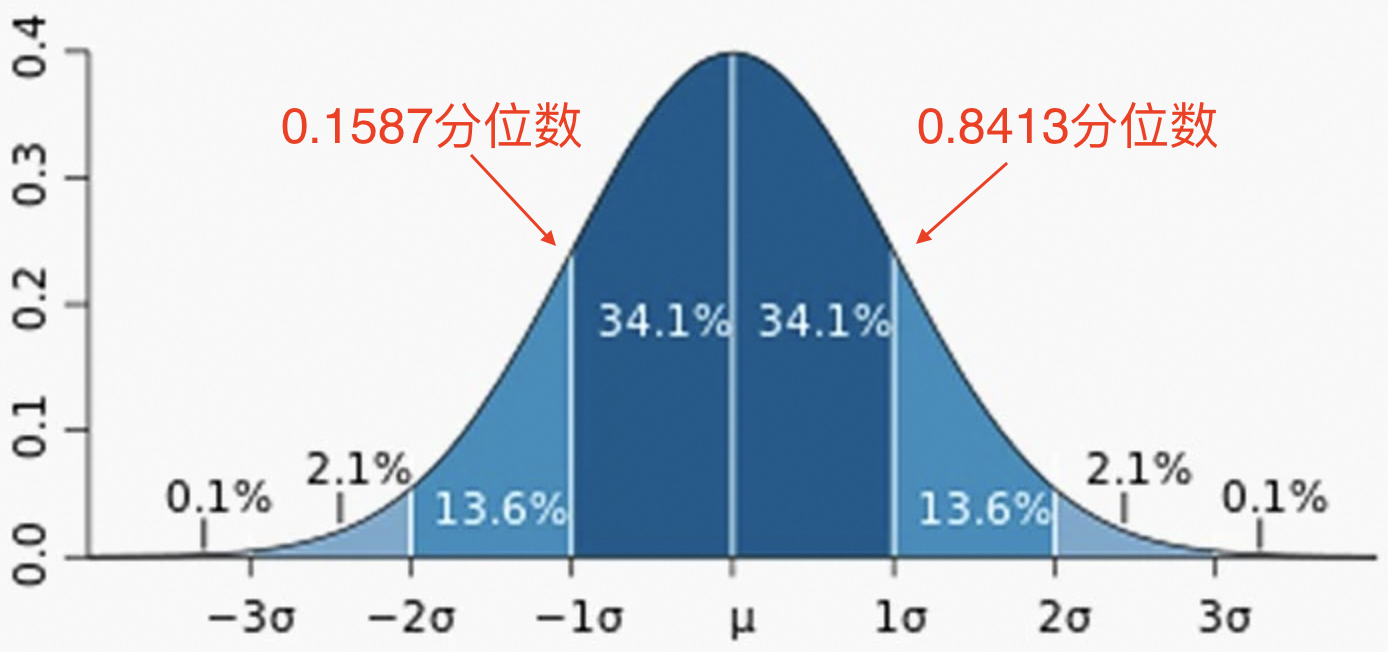

In [28]:
quantiles = [0.1587, 0.5, 0.8413]

def q_loss(quantiles, y_pred, target):
    losses = []
    for i, q in enumerate(quantiles):        
        errors = target - y_pred[..., i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1))
    losses = 2 * torch.cat(losses, dim=2)  # B x 283 x 3

    return losses.mean()

### CNN

In [46]:
from ariel_model import ArielModel
from train_single_fold import prepare_datasets, create_dataloader

import lightning.pytorch as pl

In [36]:
nfold = 5
ifold = 0
name = 'ariel_model_test'

In [37]:
# empty output_dir
output_dir = f'experiments/{name}/{ifold}'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

In [31]:
datasets = prepare_datasets(nfold=nfold)

In [32]:
X_train, Y_train, X_val, Y_val = [d[ifold] for d in datasets]
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((538, 375, 283), (538, 283), (135, 375, 283), (135, 283))

In [33]:
model = ArielModel(backbone='mobilenet_v3_small')

In [34]:
model

ArielModel(
  (filter): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (backbone): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): Identity()
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): Identity()
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dN

In [35]:
train_loader = create_dataloader(X_train, Y_train, shuffle=True)
val_loader = create_dataloader(X_val, Y_val, shuffle=False)

In [40]:
tb_logger = pl.loggers.TensorBoardLogger(
    save_dir='experiments',
    name=name,
    version=f'{ifold}',
)

csv_logger = pl.loggers.CSVLogger(
    save_dir='experiments',
    name=name,
    version=f'{ifold}',
)

In [41]:
trainer = pl.Trainer(
    logger=[tb_logger, csv_logger],
    max_epochs=300,
    accelerator='gpu', 
    devices=[ifold % 2],
    log_every_n_steps=len(train_loader),  # log every epoch
    enable_progress_bar=True,
    callbacks=[pl.callbacks.ModelCheckpoint(save_last=True), pl.callbacks.RichProgressBar()],
)

trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ filter   │ Sequential  │     27 │
│ 1 │ backbone │ MobileNetV3 │  2.4 M │
└───┴──────────┴─────────────┴────────┘
Trainable params: 2.4 M                                                                                                                  
Non-trainable params: 0                                                                                                                  
Total params: 2.4 M                                                                                                                      
Total estimated model params size (MB): 9                                                                                                


Output()

/usr/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: 
The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init
to improve performance.
  rank_zero_warn(

/usr/lib/python3.8/site-packages/lightning/fabric/loggers/csv_logs.py:183: UserWarning: Experiment logs directory experiments/ariel_model_test/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


/usr/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: 
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init
to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=300` reached.


### 计算CV

In [49]:
import ariel_model
from metrics import ariel_score

In [43]:
trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[0],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
out_dir = 'experiments/mobilenet_v3_small_aug_5fold2/'

In [56]:
all_preds = []
all_labels = []
for ifold in tqdm(range(nfold)):
    X_val, Y_val = datasets[2][ifold], datasets[3][ifold]
    val_loader = create_dataloader(X_val, Y_val, shuffle=False)
    model = ArielModel.load_from_checkpoint(f'{out_dir}/{ifold}/checkpoints/last.ckpt')
    preds = trainer.predict(model, dataloaders=val_loader)
    all_preds += preds
    all_labels.append(Y_val)

  0%|                                                                                                                                                      | 0/5 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

 20%|████████████████████████████▍                                                                                                                 | 1/5 [00:00<00:03,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

 40%|████████████████████████████████████████████████████████▊                                                                                     | 2/5 [00:01<00:02,  1.20it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3/5 [00:02<00:01,  1.25it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4/5 [00:03<00:00,  1.27it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.25it/s]


In [57]:
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
all_preds.shape, all_labels.shape

((673, 283, 3), (673, 283))

In [58]:
all_preds_mean = all_preds[:, :, 1]  # N x 283
all_preds_sigma = (all_preds[:, :, 2] - all_preds[:, :, 0]) # / 2  # N x 283

metric = ariel_score(
    all_labels,
    np.concatenate([all_preds_mean.clip(0), all_preds_sigma.clip(0)], axis=1),
    all_labels.mean(),
    all_labels.std(),
    sigma_true=1e-5
)

In [59]:
metric

0.5529588036465999